In [8]:
import pandas as pd
import numpy as np
import os
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

os.chdir("/home/william/Desktop")

In [9]:
datosTicTacToe = pd.read_csv("tic-tac-toe.csv")

In [10]:
for x in datosTicTacToe:
    if x != " Gana-x":
        datosTicTacToe[x] = datosTicTacToe[x].astype('category')
datosTicTacToe.dtypes

cuadro-superior-izquierdo     category
 cuadro-superior-medio        category
 cuadro-superior-derecho      category
 cuadro-medio-izquierdo       category
 cuadro-medio-medio           category
  cuadro-medio-derecho        category
 cuadro-inferior-izquierdo    category
 cuadro-inferior-medio        category
 cuadro-inferior-derecho      category
 Gana-x                         object
dtype: object

In [11]:
datosTicTacToePosiblesResultados = list(set(datosTicTacToe.iloc[:, -1]))

In [12]:
class PrediccionBase:
    def __init__(self, datos):
        self.__datos = self.cleaning(datos)
        self.__precisionGlobal = 0
        self.__error_global = 0
        self.__verdaderosNegativos = 0
        self.__falsosPositivos = 0
        self.__falsosNegativos = 0
        self.__verdaderosPositivos = 0
        self.__reporte = 0
        self.__precision_category = 0

    @property
    def datos(self):
        return self.__datos

    @property
    def reporte(self):
        return self.__reporte

    def cleaning(self, datos):
        datos = datos.replace({'x': 0, 'o': 1, 'b': 2})
        return datos

    def entrenamiento(self):
        pass

    def generacionReporte(self, nombreDelModelo):
        dict = {
            "Modelo": [nombreDelModelo],
            "Precision Global": [self.__precisionGlobal],
            "Error Global": [self.__error_global],
            "Verdaderos Positivos": [self.__verdaderosPositivos],
            "Verdaderos Negativos": [self.__verdaderosNegativos],
            "Falsos Negativos": [self.__falsosNegativos],
            "Falsos Positivos": [self.__falsosPositivos]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC, modelo):
        self.__verdaderosNegativos, self.__falsosPositivos, self.__falsosNegativos, self.__verdaderosPositivos = MC.ravel()
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__error_global = 1 - self.__precisionGlobal
        self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        self.__precision_category.columns = ["Precision Positiva (PP)", "Precision Negativa (PN)"]
        self.generacionReporte(modelo)
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}


class PrediccionKNeighbors(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)

    def entrenamiento(self, nucleo="auto", n_neighbors=3, train_size=0.80):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        instancia_knn = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=nucleo)
        instancia_knn.fit(X_train, y_train)
        prediccion = instancia_knn.predict(X_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "KNeighbors")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionArbolBinario(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None

    def graficar(self):
        datos_plotear = export_graphviz(self.__instancia, out_file=None, class_names=list(set(self.datos.iloc[:, -1])),
                                        feature_names=list(self.datos.iloc[:, :-1].columns.values), filled=True)
        grafico = graphviz.Source(datos_plotear)
        return grafico

    def entrenamiento(self, train_size=0.80):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia = DecisionTreeClassifier()
        self.__instancia.fit(x_train, y_train)
        prediccion = self.__instancia.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Arbol de Decisiones")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


<div>
    <p>Esto seria el analisis del Arbol binario</p>
</div>

In [13]:
datosTicTacToe.dtypes

cuadro-superior-izquierdo     category
 cuadro-superior-medio        category
 cuadro-superior-derecho      category
 cuadro-medio-izquierdo       category
 cuadro-medio-medio           category
  cuadro-medio-derecho        category
 cuadro-inferior-izquierdo    category
 cuadro-inferior-medio        category
 cuadro-inferior-derecho      category
 Gana-x                         object
dtype: object

In [14]:
prediccionArbol = PrediccionArbolBinario(datos=datosTicTacToe)
prediccionArbol.entrenamiento()


Matriz de Confusión:
[[ 58  16]
 [  5 113]]

Precisión Global:
0.890625

Error Global:
0.109375

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.783784                 0.957627


<div>
    <p>Esto seria el analisis del  KNeighbors</p>
</div>

In [15]:
prediccionKNeighbors = PrediccionKNeighbors(datos=datosTicTacToe)
prediccionKNeighbors.entrenamiento()


Matriz de Confusión:
[[ 46  28]
 [  1 117]]

Precisión Global:
0.8489583333333334

Error Global:
0.15104166666666663

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.621622                 0.991525


<div>
    <p>De acuerdo con el proximo reporte el mejor modelo seria el de Arboles de decision, por que tiene mas preciosion global, ademas de menos error global, y la precision positiva es superior en 0,17 unidades.</p>
    <p>En general basicamente es superior en todos los aspectos exepto en la preicision negativa, en este aspecto es inferior pero por muy poco, pero considero que no es tanto para ganarle al de los Arboles de decision</p>
</div>

In [16]:
reporteFinal = pd.concat([prediccionKNeighbors.reporte, prediccionArbol.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,KNeighbors,0.848958,0.151042,117,46,1,28,0.621622,0.991525
0,Arbol de Decisiones,0.890625,0.109375,113,58,5,16,0.783784,0.957627


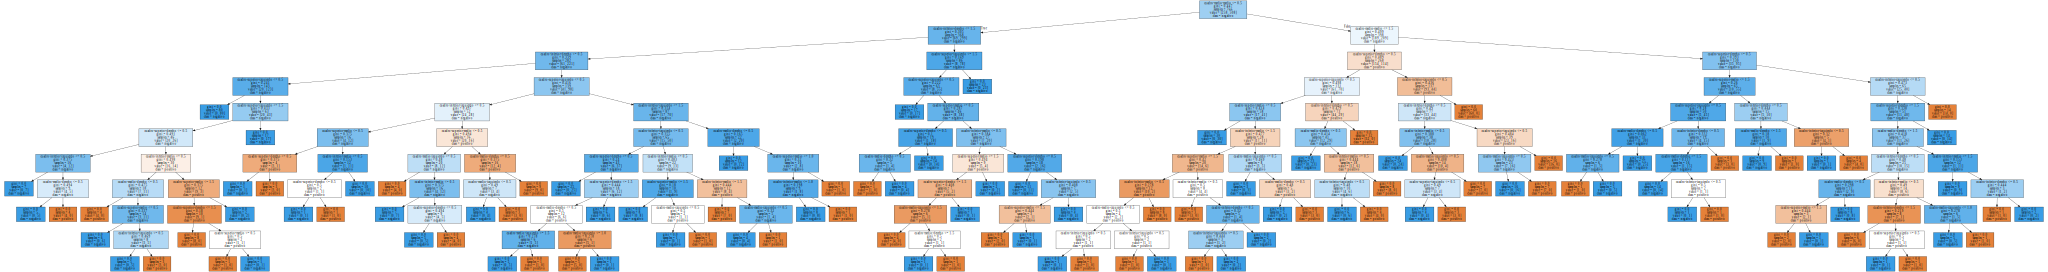

In [17]:
prediccionArbol.graficar()

En este caso es el primer elemento del arbol binario el elemento ROOT de todos, como podemos ver tenemos la regla que basicamente lo que dice es que si la variable cuadro-medio-medio es menor a 0.5, se va a un lado del arbol al lado izquierda y eso hace que tenga un flujo completamente distinto del caso cuando es mayor 0.5  


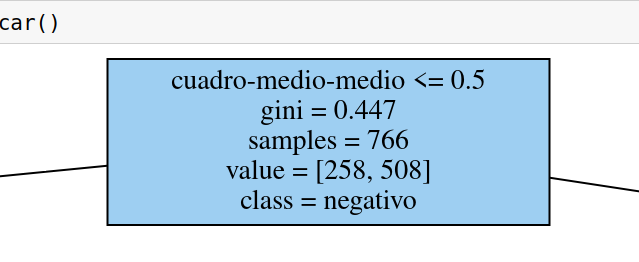

En este otro caso vemos cuando tenemos una hoja del arbol, aqui lo que podemos ver es que en este caso no hay condicionales por que muestra el ultimo valor del arbol de decisiones 

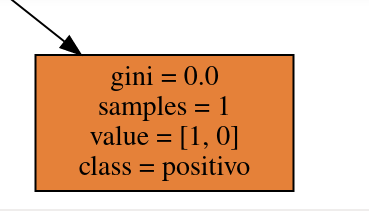

In [18]:
datosWine = pd.read_csv("wine.csv")
datosWine.dtypes

fija.acidez              float64
volatil.acidez           float64
citrica.acidez           float64
residual.azucar          float64
cloruros                 float64
libre.sulfuro.dioxido    float64
total.sulfuro.dioxido    float64
densidad                 float64
pH                       float64
sulfitos                 float64
alcohol                  float64
calidad                    int64
tipo                      object
dtype: object

In [19]:
prediccionArbolWine = PrediccionArbolBinario(datosWine)
prediccionArbolWine.entrenamiento()


Matriz de Confusión:
[[975   2]
 [ 10 313]]

Precisión Global:
0.9907692307692307

Error Global:
0.009230769230769265

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.997953                  0.96904


In [20]:
prediccionKNeighborsWine = PrediccionKNeighbors(datosWine)
prediccionKNeighborsWine.entrenamiento()
prediccionKNeighborsWine.reporte

reporteFinal = pd.concat([prediccionKNeighborsWine.reporte, prediccionArbolWine.reporte])
reporteFinal


Matriz de Confusión:
[[941  36]
 [ 51 272]]

Precisión Global:
0.933076923076923

Error Global:
0.06692307692307697

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.963153                 0.842105


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,KNeighbors,0.933077,0.066923,272,941,51,36,0.963153,0.842105
0,Arbol de Decisiones,0.990769,0.009231,313,975,10,2,0.997953,0.969040


En este caso el Arbol de Decisiones predice mucho mejor que el KNeighbors y eso lo podemos ver por la precision global y que tiene un error global menor

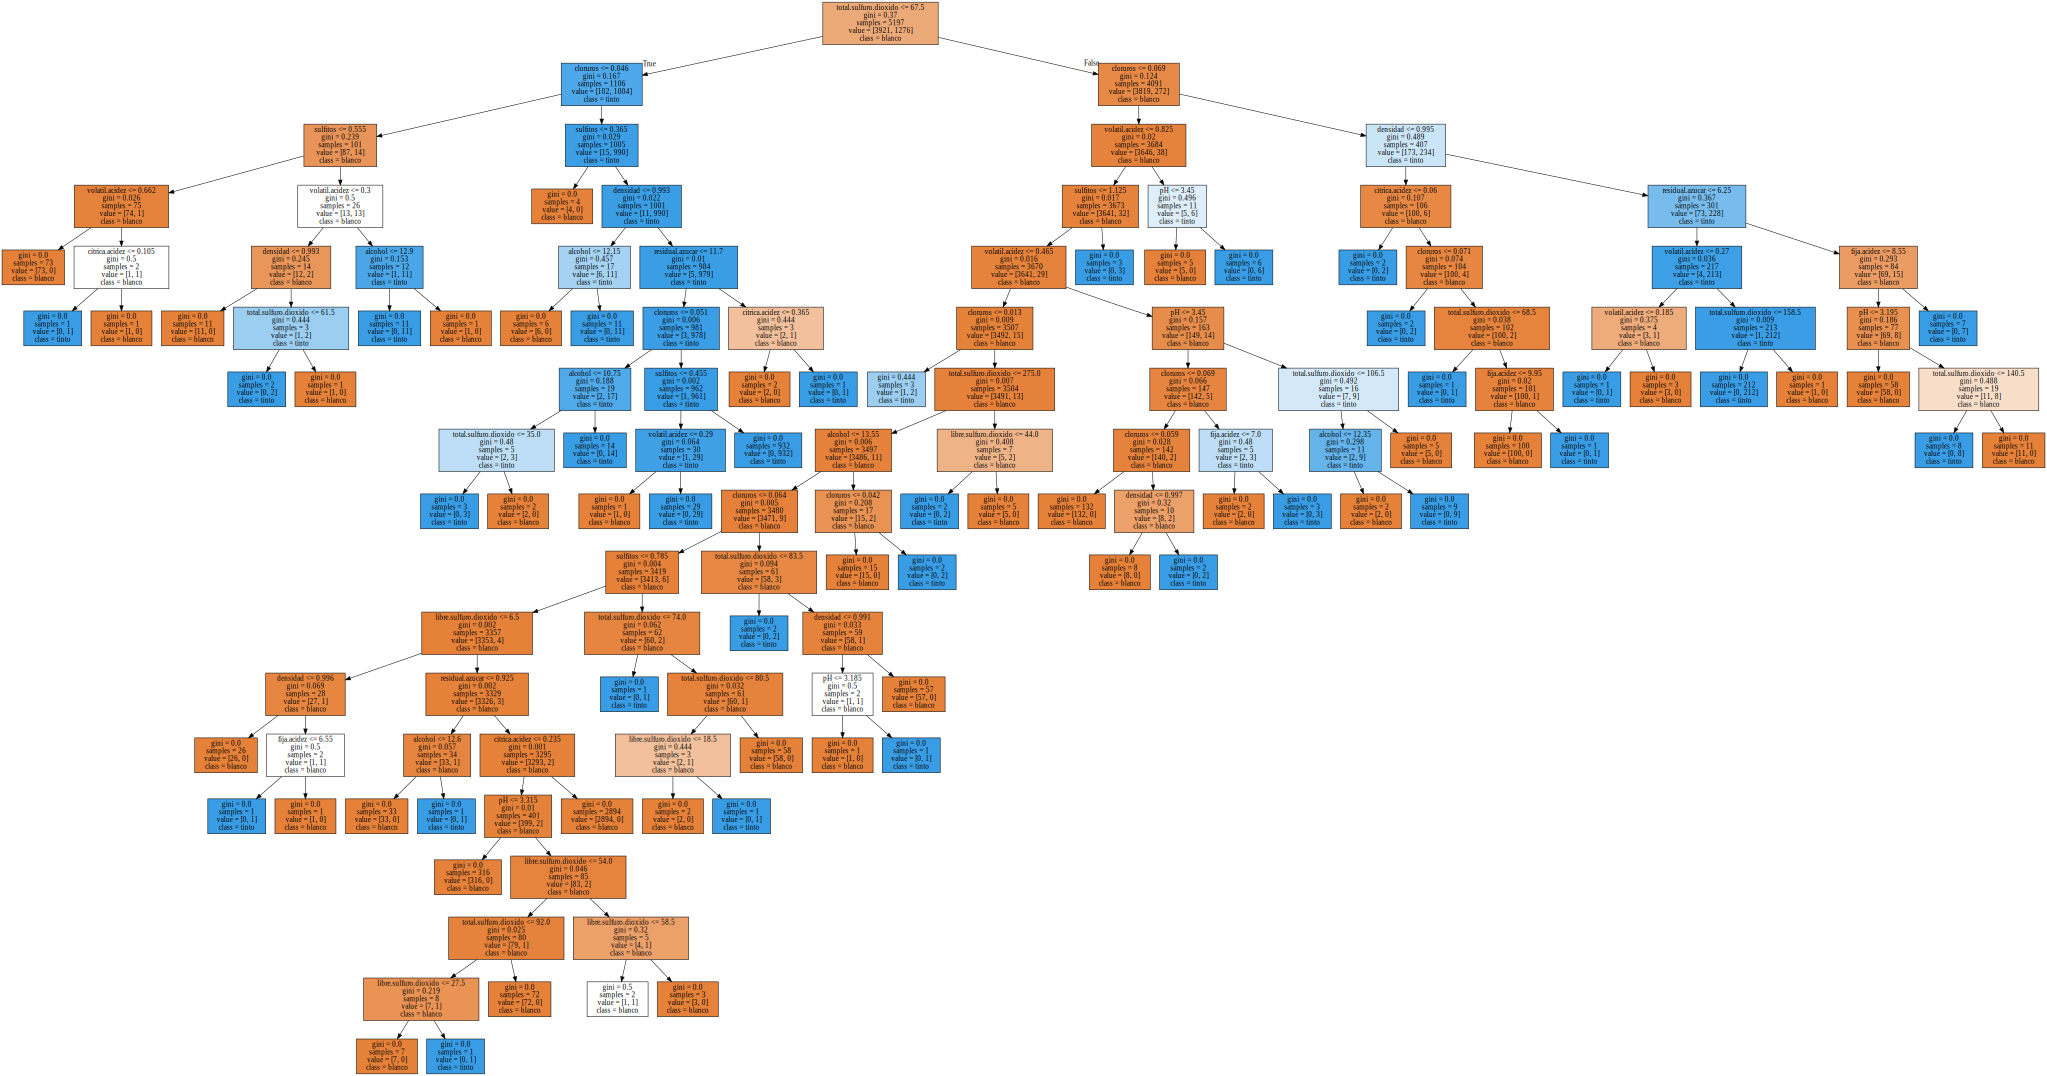

In [21]:
prediccionArbolWine.graficar()

En este caso es el primer elemento del arbol binario el elemento ROOT de todos, como podemos ver en la imagen parece que utiliza la variable total.sulfuritos.dioxido como principal y apartir de ahi construye las demas estructuras del arbol binario, si ese valor es menor o igual a 67.5 aplica un camino del arbol binario y si no aplica uno completamente distinto

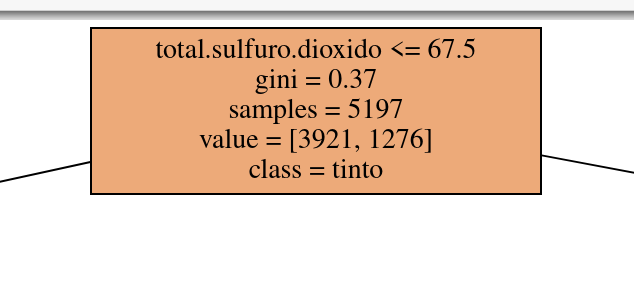


En este caso podemos ver como la variable sulfitos muestra una regla interesante, por que si se cumple la condicion entonces la prediccion termina por que llega una hoja del arbol, y si no entonces siginifica que sigue por el camnino hasta llegar a una hoja tal vez luego de pasar por mas caminos

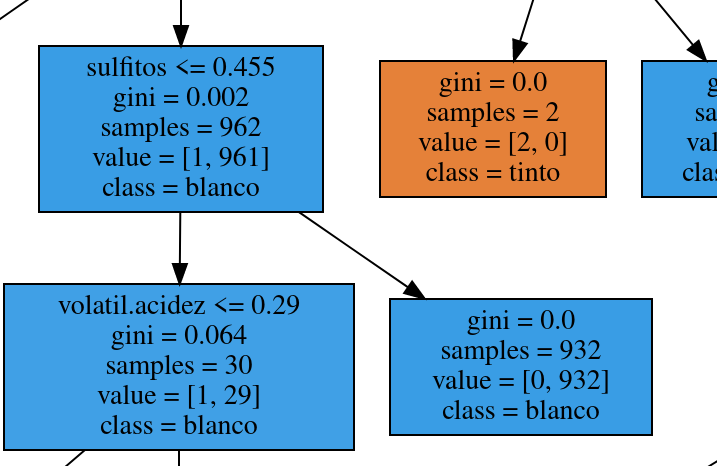

   fija.acidez  volatil.acidez  citrica.acidez  residual.azucar  cloruros  \
0          6.2            0.30            0.21              1.1     0.032   
1          6.6            0.61            0.01              1.9     0.080   
2          6.4            0.32            0.23             16.2     0.055   
3          7.0            0.22            0.29              8.9     0.050   
4          6.4            0.43            0.27              1.1     0.054   

   libre.sulfuro.dioxido  total.sulfuro.dioxido  densidad    pH  sulfitos  \
0                   31.0                  111.0   0.98890  2.97      0.42   
1                    8.0                   25.0   0.99746  3.69      0.73   
2                   36.0                  176.0   0.99860  3.26      0.54   
3                   24.0                   90.0   0.99556  3.29      0.46   
4                    5.0                  110.0   0.99390  3.24      0.52   

   alcohol  calidad    tipo  
0     12.2        6  blanco  
1     10.5    

<ipython-input-22-a974d773f5d4>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['{:.0%}'.format(x) for x in vals])


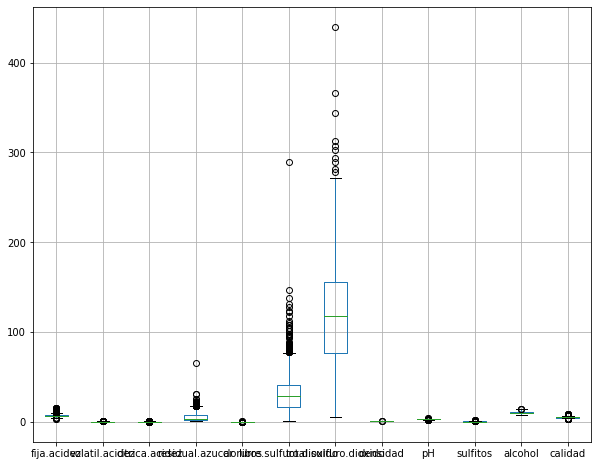

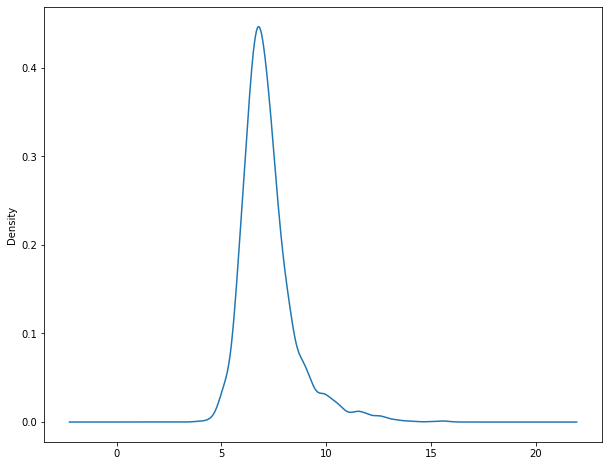

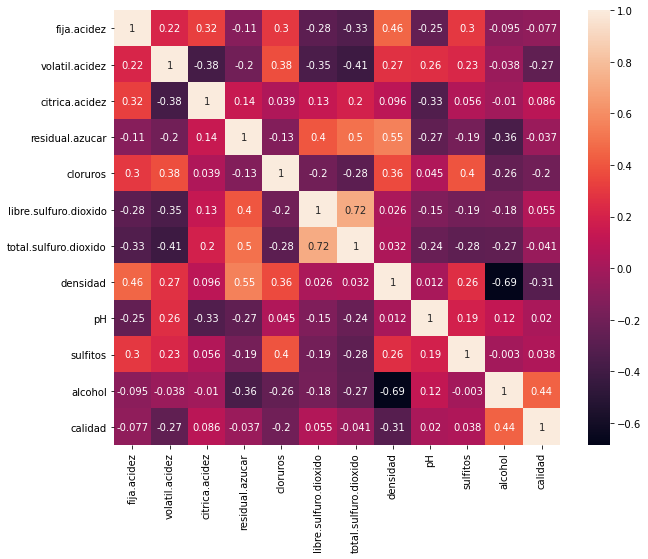

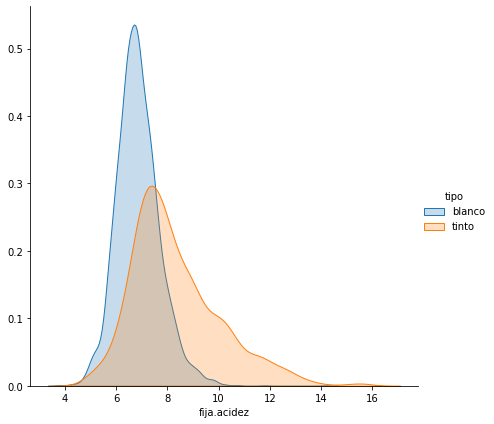

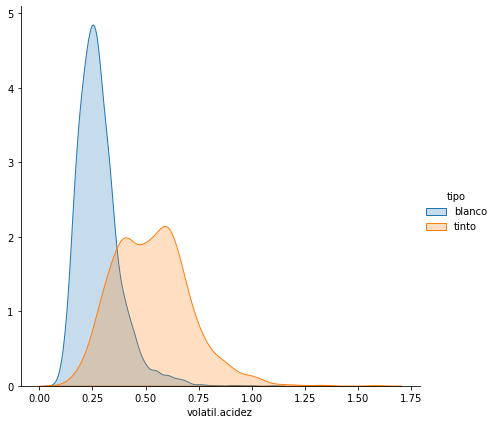

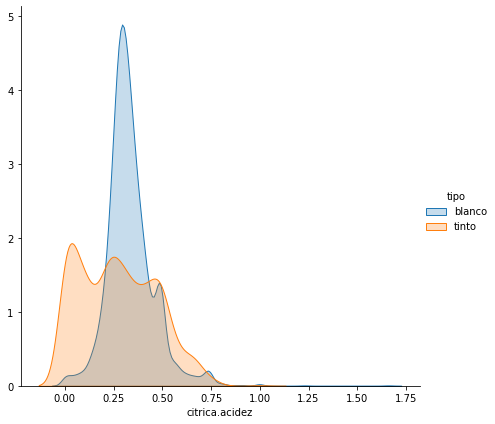

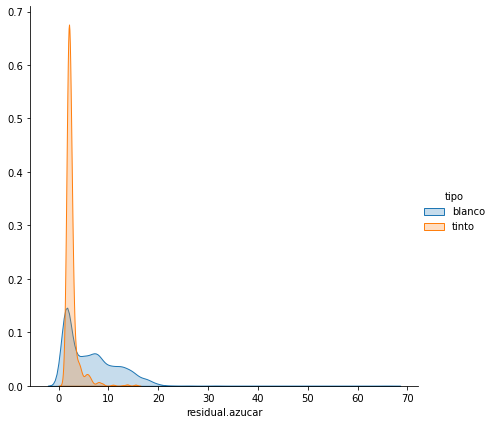

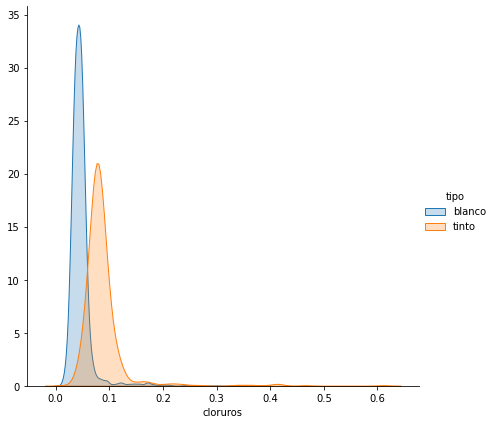

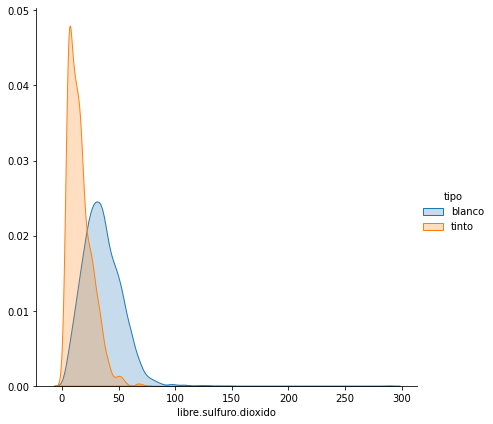

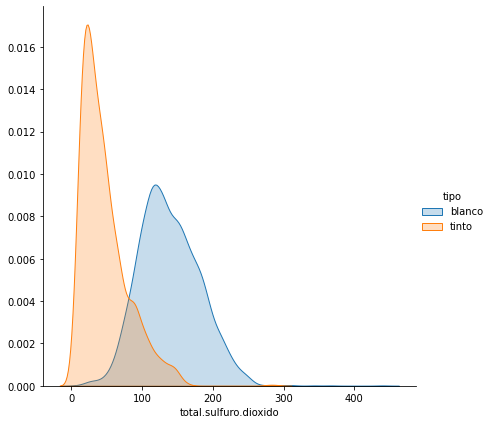

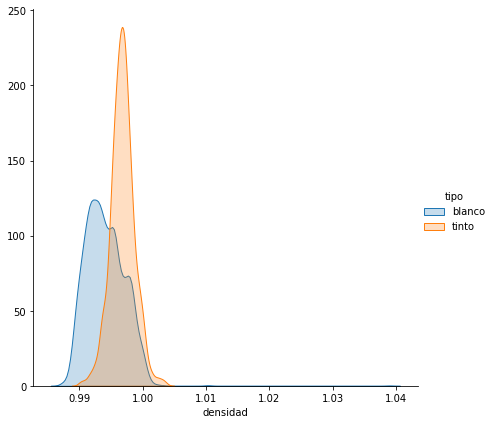

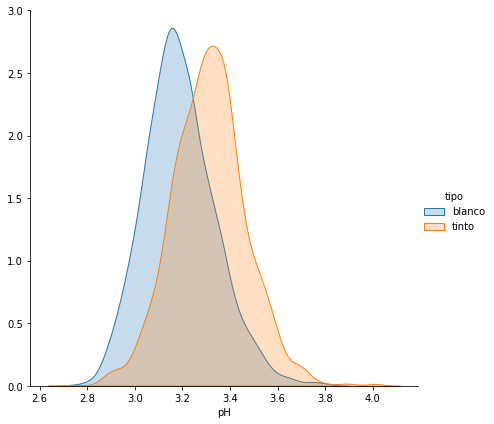

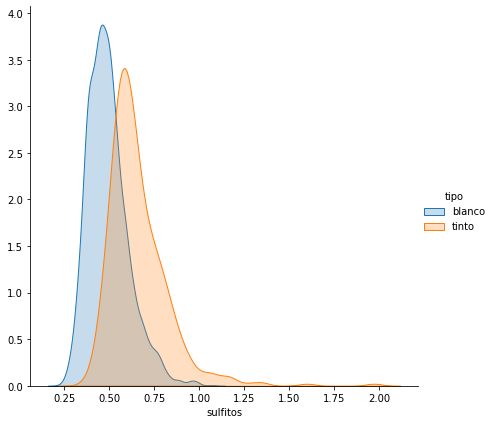

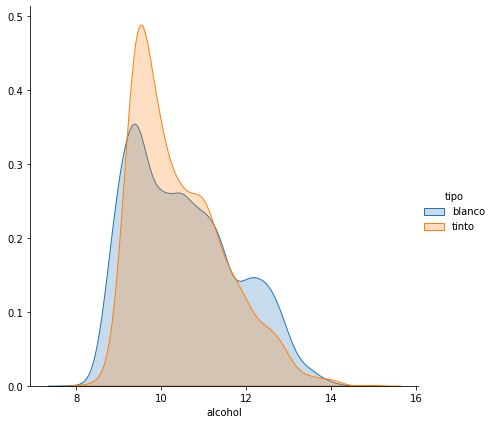

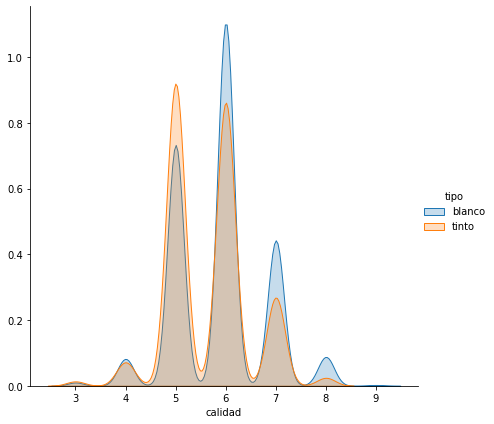

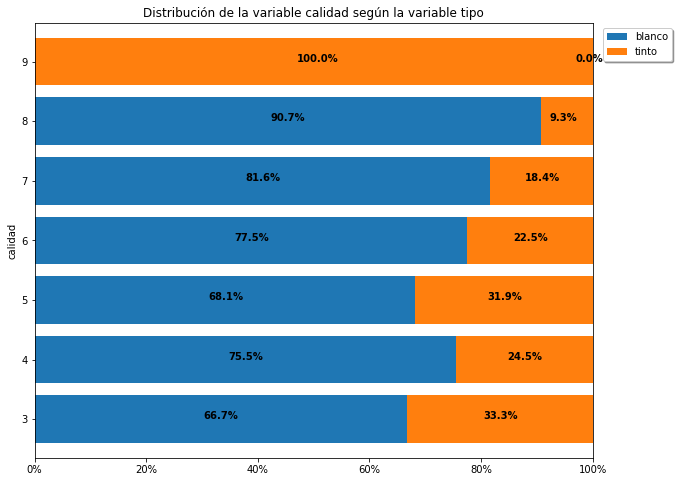

In [22]:
class Exploracion:
    def __init__(self, df):
        self.__df = df

    def analisis(self):
        print(self.__df.head())
        print(self.__df.shape)
        print(self.__df.quantile(np.array([0, .25, .50, .75, 1])))

        f, ax = plt.subplots(figsize=(10, 8))
        self.__df.boxplot(return_type='axes')
        f, ax = plt.subplots(figsize=(10, 8))
        self.__df[self.__df.columns[0]].plot(kind='density')
        correlation_mat = self.__df.corr()
        f, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(correlation_mat, annot=True)

        for x in self.__df:
            if x != "tipo":
                self.poder_predictivo_numerica(x, "tipo")
        self.poder_predictivo_categorica("calidad", "tipo")

    def poder_predictivo_numerica(self, var: str, variable_predict: str):
        sns.FacetGrid(self.__df, hue=variable_predict, height=6).map(sns.kdeplot, var, shade=True).add_legend()

    def poder_predictivo_categorica(self, var, variable_predict):
        df = pd.crosstab(index=self.__df[var], columns=self.__df[variable_predict])
        df = df.div(df.sum(axis=1), axis=0)
        titulo = "Distribución de la variable %s según la variable %s" % (var, variable_predict)
        g = df.plot(kind='barh', stacked=True, legend=True, figsize=(10, 8),
                    xlim=(0, 1), title=titulo, width=0.8)
        vals = g.get_xticks()
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        for bars in g.containers:
            plt.setp(bars, width=2)
        for i in range(df.shape[0]):
            countv = 0
            for v in df.iloc[i]:
                g.text(np.mean([countv, countv + v]) - 0.03, i, '{:.1%}'.format(v), color='black', fontweight='bold')
                countv = countv + v

    def entrenamiento(self, nucleo="auto", n_neighbors=3, x=None):
        if x is None:
            x = self.__df.iloc[:, :-1]
        y = self.__df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=0)
        instancia_knn = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=nucleo)
        instancia_knn.fit(X_train, y_train)
        prediccion = instancia_knn.predict(X_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, list(np.unique(y)))
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))

    def analsis(self, MC, nombres=None):
        precision_global = np.sum(MC.diagonal()) / np.sum(MC)
        error_global = 1 - precision_global
        precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        if nombres is not None:
            precision_category.columns = nombres
        return {"Matriz de Confusión": MC,
                "Precisión Global": precision_global,
                "Error Global": error_global,
                "Precisión por categoría": precision_category}

    def distribucion_variable_predecir(self, variable_predict: str):
        colors = list(dict(**mcolors.CSS4_COLORS))
        df = pd.crosstab(index=self.__df[variable_predict], columns="valor") / self.__df[variable_predict].count()
        fig = plt.figure(figsize=(10, 9))
        g = fig.add_subplot(111)
        countv = 0
        titulo = "Distribución de la variable %s" % variable_predict
        for i in range(df.shape[0]):
            g.barh(1, df.iloc[i], left=countv, align='center', color=colors[11 + i], label=df.iloc[i].name)
            countv = countv + df.iloc[i]
        vals = g.get_xticks()
        g.set_xlim(0, 1)
        g.set_yticklabels("")
        g.set_title(titulo)
        g.set_ylabel(variable_predict)
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        countv = 0
        for v in df.iloc[:, 0]:
            g.text(np.mean([countv, countv + v]) - 0.03, 1, '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)


datosWine = pd.read_csv("wine.csv")
exploracion = Exploracion(datosWine)
exploracion.analisis()

El analisis anterior fue para ver cuales son las variables que tienen mas importancia dentro del analisis. el resultado fue que las mas importantes son: "volatil.acidez", "cloruros", "total.sulfuro.dioxido",
                                             "libre.sulfuro.dioxido", "sulfitos", "densidad", "tipo"

In [23]:
datosWine = pd.read_csv("wine.csv", delimiter=",", sep=".", index_col=None, header=0)
datosWine = pd.DataFrame(datosWine, columns=["volatil.acidez", "cloruros", "total.sulfuro.dioxido",
                                             "libre.sulfuro.dioxido", "sulfitos", "densidad", "tipo"])

<div>
    <p>Esto seria el analisis del Arbol binario</p>
</div>

In [24]:
prediccionArbolWineSeisVariables = PrediccionArbolBinario(datos=datosWine)
prediccionArbolWineSeisVariables.entrenamiento()


Matriz de Confusión:
[[973   4]
 [  7 316]]

Precisión Global:
0.9915384615384616

Error Global:
0.00846153846153841

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.995906                 0.978328


<div>
    <p>Esto seria el analisis del  KNeighbors</p>
</div>

In [25]:
prediccionKNeighborsSeisVariables = PrediccionKNeighbors(datos=datosWine)
prediccionKNeighborsSeisVariables.entrenamiento()


Matriz de Confusión:
[[931  46]
 [ 71 252]]

Precisión Global:
0.91

Error Global:
0.08999999999999997

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.952917                 0.780186


In [26]:

class PrediccionNumerosBase:
    def __init__(self, datosTest, datosTrain):
        self.__datosTest = datosTest
        self.__datosTrain = datosTrain

        self.__x_train, self.__x_test, self.__y_train, self.__y_test = (
            self.__datosTrain.iloc[:, 1:], self.__datosTest.iloc[:, 1:],
            self.__datosTrain.iloc[:, 0].values, self.__datosTest.iloc[:, 0].values)

        self.__precisionGlobal = 0
        self.__error_global = 0
        self.__reporte = 0
        self.__precision_category = 0

    @property
    def X_Train(self):
        return self.__x_train

    @property
    def X_Test(self):
        return self.__x_test

    @property
    def Y_Train(self):
        return self.__y_train

    @property
    def Y_Test(self):
        return self.__y_test

    @property
    def datosTrain(self):
        return self.__datosTrain

    @property
    def reporte(self):
        return self.__reporte

    def entrenamiento(self):
        pass

    def generacionReporte(self, nombreDelModelo):
        dict = {
            "Modelo": [nombreDelModelo],
            "Precision Global": [self.__precisionGlobal],
            "Error Global": [self.__error_global]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC, modelo, columns=None):
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__error_global = 1 - self.__precisionGlobal

        if columns is not None:
            print(pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).columns)
            self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
            self.__precision_category.columns = columns
        else:
            self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T

        self.generacionReporte(modelo)
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}


class PrediccionNumerosKNeighbors(PrediccionNumerosBase):
    def __init__(self, datosTest, datosTrain):
        super().__init__(datosTest, datosTrain)

    def entrenamiento(self, nucleo="auto", n_neighbors=3, train_size=0.80, columns=None):
        instancia_knn = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=nucleo)
        instancia_knn.fit(self.X_Train, self.Y_Train)
        prediccion = instancia_knn.predict(self.X_Test)
        MC = confusion_matrix(self.Y_Test, prediccion)
        if columns is not None:
            indices = self.analsis(MC, "KNeighbors", columns=columns)
        else:
            indices = self.analsis(MC, "KNeighbors")

        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionNumerosArbolBinario(PrediccionNumerosBase):
    def __init__(self, datosTest, datosTrain):
        super().__init__(datosTest, datosTrain)
        self.__instancia = None

    def entrenamiento(self, train_size=0.80, columns=None):
        self.__instancia = DecisionTreeClassifier()
        self.__instancia.fit(self.X_Train, self.Y_Train)
        prediccion = self.__instancia.predict(self.X_Test)
        if columns is not None:
            MC = confusion_matrix(self.Y_Test, prediccion, columns)
        else:
            MC = confusion_matrix(self.Y_Test, prediccion)

        if columns is not None:
            indices = self.analsis(MC, "Arbol de Decisiones", columns=columns)
        else:
            indices = self.analsis(MC, "Arbol de Decisiones")

        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))

In [27]:
dataTrain = pd.read_csv("ZipDataTrainCod.csv", delimiter=";", sep=".", index_col=None, header=0)
dataTest = pd.read_csv("ZipDataTestCod.csv", delimiter=";", sep=".", index_col=None, header=0)



<p>Tarea 1 ejercicio 4 anterior</p>

In [28]:
prediccionNumerosKNeighbors = PrediccionNumerosKNeighbors(dataTest, dataTrain)
prediccionNumerosKNeighbors.entrenamiento()


Matriz de Confusión:
[[355   1   0   2   1   0   0   0   0   0]
 [  5 145   0   2   4   1   0   0   3   0]
 [  0   2 183   0   8   1   2   2   0   2]
 [  8   0   2 182   0   3   0   2   1   0]
 [  2   0   3   0 168   0   0   4   0   0]
 [  4   2   0   2   2 151   0   1   4   0]
 [  3   1   2   1   0   0 163   0   0   0]
 [  0   0   4   1   1   1   0 138   1   1]
 [  3   6   0   2   1   0   0   1 153   0]
 [  0   0   4   0   0   0   2   1   0 257]]

Precisión Global:
0.9441953163926258

Error Global:
0.05580468360737423

Precisión por categoría:
          0        1      2         3         4         5         6         7  \
0  0.988858  0.90625  0.915  0.919192  0.949153  0.909639  0.958824  0.938776   

          8         9  
0  0.921687  0.973485  


In [29]:
prediccionNumerosArbolBinario = PrediccionNumerosArbolBinario(dataTest, dataTrain)
prediccionNumerosArbolBinario.entrenamiento()


Matriz de Confusión:
[[333   3   2   6   1   3   5   1   5   0]
 [  8 111   7   5   3   2   6   3  15   0]
 [  3   3 155  10   9   4   5   2   5   4]
 [  8   2   9 152   2  13   5   2   5   0]
 [  2   3   9   3 146   5   0   5   0   4]
 [  4   7   8   7  10 117   5   3   4   1]
 [  2   4   4  11   0   5 140   0   2   2]
 [  0   3   7   1   4   0   2 126   2   2]
 [  4  16   1   5   7   3   3   0 126   1]
 [  0   0   4   0   2   4   3   1   0 250]]

Precisión Global:
0.8251121076233184

Error Global:
0.17488789237668156

Precisión por categoría:
          0        1      2         3         4         5         6         7  \
0  0.927577  0.69375  0.775  0.767677  0.824859  0.704819  0.823529  0.857143   

          8        9  
0  0.759036  0.94697  


In [30]:
pd.concat([prediccionNumerosKNeighbors.reporte,prediccionNumerosArbolBinario.reporte])

,Modelo,Precision Global,Error Global,0,1,2,3,4,5,6,7,8,9
0,KNeighbors,0.944195,0.055805,0.988858,0.90625,0.915,0.919192,0.949153,0.909639,0.958824,0.938776,0.921687,0.973485
0,Arbol de Decisiones,0.825112,0.174888,0.927577,0.69375,0.775,0.767677,0.824859,0.704819,0.823529,0.857143,0.759036,0.946970


En este caso el modelo de KNeighbors es mejor que el modelo de Arbol de decision.

In [31]:
filtro = ["tres", "cinco", "ocho"]
dataTrain = dataTrain[[(x in filtro) for x in dataTrain.iloc[:, 0].values]]
dataTest = dataTest[[(x in filtro) for x in dataTest.iloc[:, 0].values]]

In [32]:
prediccionNumerosKNeighborsFiltrado = PrediccionNumerosKNeighbors(dataTest, dataTrain)
prediccionNumerosKNeighborsFiltrado.entrenamiento(columns=["tres", "cinco", "ocho"])

RangeIndex(start=0, stop=1, step=1)

Matriz de Confusión:
[[155   1   4]
 [  4 158   4]
 [ 12   0 154]]

Precisión Global:
0.9491869918699187

Error Global:
0.05081300813008127

Precisión por categoría:
      tres     cinco      ocho
0  0.96875  0.951807  0.927711


In [33]:
prediccionNumerosArbolBinarioFiltrado = PrediccionNumerosArbolBinario(dataTest, dataTrain)
prediccionNumerosArbolBinarioFiltrado.entrenamiento(columns=["tres", "cinco", "ocho"])

RangeIndex(start=0, stop=1, step=1)

Matriz de Confusión:
[[135  19  12]
 [ 14 132  14]
 [ 11  12 143]]

Precisión Global:
0.8333333333333334

Error Global:
0.16666666666666663

Precisión por categoría:
       tres  cinco      ocho
0  0.813253  0.825  0.861446


/home/william/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['tres', 'cinco', 'ocho'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [34]:
pd.concat([prediccionNumerosKNeighborsFiltrado.reporte,prediccionNumerosArbolBinarioFiltrado.reporte])

,Modelo,Precision Global,Error Global,tres,cinco,ocho
0,KNeighbors,0.949187,0.050813,0.968750,0.951807,0.927711
0,Arbol de Decisiones,0.833333,0.166667,0.813253,0.825000,0.861446
